# Confidence Interval of Survival Data

## Introduction

**Survival analysis** is a branch of statistics that deals with the analysis of time-to-event data, often referred to as 'survival data'.

The **event** can be anything from the death of an organism (hence **'survival'**), to the failure of a mechanical system, to the recovery of a sick patient.

A **confidence interval** in survival analysis gives a range of values, derived from the data, that is likely to contain the true value of an unknown population parameter. In the context of survival analysis, a confidence interval might be used to describe the uncertainty around a survival time estimate.

## Survival data

### The `lifelines` library

In Python, the [`lifelines` library](https://lifelines.readthedocs.io/en/stable/index.html) is commonly used for survival analysis. It provides a simple and intuitive API for fitting survival models, and also includes functions for visualizing survival data. Here's a basic example of how you might calculate a confidence interval for a survival function estimate using the KaplanMeierFitter class in lifelines:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lifelines

print('lifelines version:', lifelines.__version__)

lifelines version: 0.28.0


In [2]:
from lifelines import KaplanMeierFitter

# Assume we have some survival data in the following two lists:
# `durations` is a list of durations until the event or censorship
# `event_observed` is a binary list where 1 indicates the event, 
# i.e., death, occurred, and 0 indicates censorship

# example of the survival data from pages 47-48 of the book Intuitive Biostatistics
durations = [4.07, 6.54, 1.39, 6.17, 5.89, 4.76, 3.67]
event_observed  = [  1 ,  0  ,  1  ,  0  ,  1  ,  1  ,  0  ]

# we create a dataframe with those data
data = pd.DataFrame(
    {
        'YEARS': durations,
        'EVENT': event_observed,
    }
)

# sorted durations
data.sort_values(by='EVENT')

,YEARS,EVENT
1,6.54,0
3,6.17,0
6,3.67,0
0,4.07,1
2,1.39,1
4,5.89,1
5,4.76,1


In [3]:
# Create a fitter instance
kmf = KaplanMeierFitter()

# Fit the data to the model
kmf.fit(
    durations=durations,
    event_observed=event_observed,
)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7 total observations, 3 right-censored observations>

The `kmf._median` attribute gives us the **median survival time**. In the context of survival analysis, the median survival time is the smallest time at which the survival probability drops to 0.5 or below. In other words, it's the time by which half of the population has experienced the event of interest.

In [4]:
print("Median survival time:", kmf.median_survival_time_)

Median survival time: 5.89


Please note that the median survival time might be `inf` (infinity) for some datasets. This happens when the survival function never goes below 0.5, which means that more than half of the population survives till the end of the observation period. In such cases, the median survival time is undefined and is conventionally considered to be infinite.

The survival function estimate and its confidence intervals can be accessed with:

In [5]:
kmf.survival_function_

,KM_estimate
timeline,
0.00,1.000000
1.39,0.857143
3.67,0.857143
4.07,0.685714
4.76,0.514286
5.89,0.342857
6.17,0.342857
6.54,0.342857


In [6]:
kmf.confidence_interval_

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.00,1.000000,1.000000
1.39,0.334054,0.978561
3.67,0.334054,0.978561
4.07,0.212797,0.912112
4.76,0.117760,0.813249
5.89,0.048108,0.685484
6.17,0.048108,0.685484
6.54,0.048108,0.685484


This gives us the survival function estimates along with their confidence intervals. The first table corresponds to the "% survival", and the second table to the "lower limit" and "upper limit" in the table 5.3 of the book.

Remember, the interpretation of confidence intervals in the context of survival data is the same as in other areas of statistics. A 95% confidence interval means that if we were to repeat our study many times, we would expect the true survival function to fall within our estimated interval in 95% of studies.

The `lifelines` API provides many other utilities, for example the function called `survival_table_from_events` is used to create a survival table given some durations and censoring vectors. The survival table provides a summary of the number of individuals at risk, the number of events, and the number of censored observations at each unique time point in the data.

In [7]:
from lifelines.utils import survival_table_from_events

# Create the survival table
table = survival_table_from_events(durations, event_observed)

print(table)

          removed  observed  censored  entrance  at_risk
event_at                                                
0.00            0         0         0         7        7
1.39            1         1         0         0        7
3.67            1         0         1         0        6
4.07            1         1         0         0        5
4.76            1         1         0         0        4
5.89            1         1         0         0        3
6.17            1         0         1         0        2
6.54            1         0         1         0        1


This prints a DataFrame that includes the following columns:

- `removed`: the number of individuals that had an event or were censored at each time point.
- `observed`: the number of individuals that had an event at each time point.
- `censored`: the number of individuals that were censored at each time point.
- `entrance`: the number of individuals that entered the risk set at each time point. This is usually 0 for all time points except the first one.
- `at_risk`: the number of individuals that are at risk of having an event at each time point.

And `lifelines.utils.survival_events_from_table` is the inverse of the function survival_table_from_events:

In [8]:
# need to create new columns in order to prepare a lifelines Table
data['observed'] = data['EVENT'] == 1
data['censored'] = data['EVENT'] == 0

# Transforming survival-table data into lifelines format
from lifelines.utils import survival_events_from_table

T, E, W = survival_events_from_table(
    data.set_index('YEARS'),
    observed_deaths_col='observed',
    censored_col='censored')

print("Durations of observation:", T)

Durations of observation: [4.07 6.54 1.39 6.17 5.89 4.76 3.67]


### Plotting the survival function

We can then plot the survival function with confidence intervals using `kmf.plot_survival_function()`.

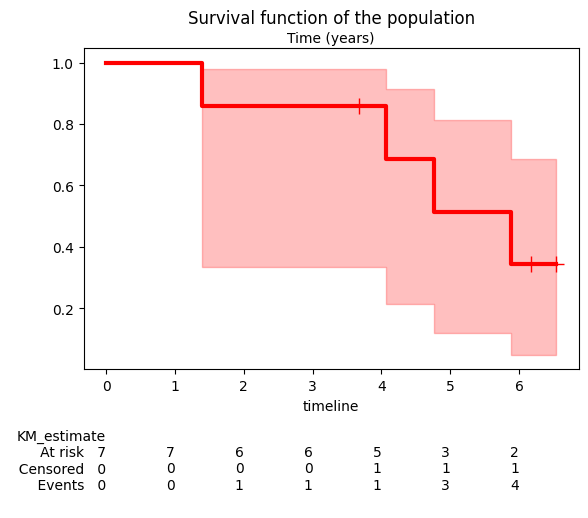

In [9]:
# let's see how it looks
plt.figure(figsize=(6,5))

kmf.plot(
    show_censors=True,
    ci_show=True,
    legend=False,
    lw=3,
    c='red',
    at_risk_counts=True, # adds summary tables below the plot
)
plt.xlabel('Time (years)')
plt.ylabel('Suvival probability estimate')
plt.title('Survival function of the population');

`kmf.plot_survival_function()` plots the Kaplan-Meier estimate of the survival function. The y-axis represents the probability that the event of interest has not yet occurred, while the x-axis represents time.

The shaded area around the survival function line represents the confidence interval. By default, it's a 95% confidence interval, meaning we are 95% confident that the true survival function lies within this area.

## Kaplan-Meier estimator

### Fraction surviving

The **fraction surviving**, often represented as $S(t)$, is a fundamental concept in survival analysis. It represents the probability that an individual survives from the time origin (t=0) to a specified future time t.

The survival function S(t), also known as the probability that life is longer than $t$, is given by $S(t) = P(T > t)$, where T is the random lifetime taken from the population.

In the context of survival analysis, "surviving" doesn't necessarily mean "not dying." Instead, it means "not experiencing the event of interest." The event could be anything: death, failure of a machine, recovery from a disease, etc.

Now, let's consider the example of the 7 individuals in the previous study. Let's focus on the 3 first events:

1. At time t1, one event (death) occurs. So, the fraction surviving drops by 1/7 (since all 7 individuals were at risk at this time). The survival probability at time t1 is thus $S(t_1) = 6/7$.
2. At time t2, one individual is censored. This means they leave the study or the study ends before they have the event. Censoring does not affect the survival probability, so $S(t_2) = S(t_1) = 6/7$.
3. At time t3, another event occurs. Now, only 5 individuals were at risk (since one event occurred at t1, reducing the at-risk group to 6, and one individual was censored at t2, further reducing the at-risk group to 5), so the fraction surviving drops by 1/5. The survival fraction at time t3 is thus $S(t_3) = S(t_2) * (1 - 1/5) = (6/7) * (4/5)$. And so on.

We can compute the surviving fractions manually as follows:

In [10]:
print(6/7)
print(6/7 * 4/5)
print(6/7 * 4/5 * 3/4)

0.8571428571428571
0.6857142857142857
0.5142857142857142


### Survival function

In survival analysis, the survival function S(t) is often estimated using the product of conditional survival probabilities. This is the basis for the Kaplan-Meier estimator, which is one of the most commonly used methods in survival analysis.

The Kaplan-Meier estimate of the survival function at time t is given by:
$$\hat{S}(t) = \prod_{k \mid t_k \le{t}}(1 - \frac{d_k}{n_k})$$

where:

- The product is over all times $t_i$ up to and including $t$ where at least one event occurred.
- $d_i$ is the number of events that occurred at time $t_i$.
- $n_i$ is the number of individuals at risk at time $t_i$, i.e., the number of individuals who have not yet had an event and have not been censored before time $t_i$.

This product ensures that the survival function estimate is properly adjusted at each time an event occurs, taking into account the decreasing number of individuals at risk.

Also note that
$$\hat{S}(t_j) = \prod_{i=1}^j\frac{n_i - d_i}{n_i} = \frac{n_j - d_j}{n_j} \times \prod_{i=1}^{j-1} \frac{n_i - d_i}{n_i} = \frac{n_j - d_j}{n_j} \times \hat{S}(t_{j-1})$$

In [11]:
import numpy as np

# convert back from Series to array
durations = data['YEARS'].to_numpy()
event_observed = data['EVENT'].to_numpy()

# Sort durations and event_observed by durations
sort_indices = np.argsort(durations)
durations_sorted = durations[sort_indices]
events_sorted = event_observed[sort_indices]

n_at_risk = len(durations_sorted)  # initial number at risk
survival_prob = 1.0  # initial survival probability

for i in range(len(durations_sorted)):
    if events_sorted[i]:  # if event occurred
        survival_prob *= (1 - 1/n_at_risk)
    print(f"Time: {durations_sorted[i]}, Survival fraction S(t): {survival_prob}")
    n_at_risk -= 1  # decrease number at risk

Time: 1.39, Survival fraction S(t): 0.8571428571428572
Time: 3.67, Survival fraction S(t): 0.8571428571428572
Time: 4.07, Survival fraction S(t): 0.6857142857142858
Time: 4.76, Survival fraction S(t): 0.5142857142857143
Time: 5.89, Survival fraction S(t): 0.3428571428571429
Time: 6.17, Survival fraction S(t): 0.3428571428571429
Time: 6.54, Survival fraction S(t): 0.3428571428571429


In [12]:
# for example at t=4.07
# at the 2nd timepoint, no event were observed (censored)
(1 - 1/7) * (1 - 0/6) * (1 - 1/5)

0.6857142857142858

We won't rewrite the entire `lifelines` library, but here is an example of how we could have written the Kaplan-Meier survival function:

In [13]:
def kaplan_meier(durations, event_observed):
    """
    Estimates the survival function using the Kaplan-Meier method.

    Args:
        durations: A numpy array of event times.
        event_observed: A numpy array of indicators (1 for event, 0 for censoring) 
        at each time point.

    Returns:
        A tuple containing three numpy arrays:
            - survival_probsorted: Estimated survival probabilities at each time point (sorted).
            - events_sorted: Unique event (sorted).
            - durations_sorted: Unique event times (sorted).
            
    """

    # Sort durations and event_observed by durations
    sort_indices = np.argsort(durations)
    durations_sorted = np.array(durations)[sort_indices]
    events_sorted = np.array(event_observed)[sort_indices]

    # Initialize variables
    n_at_risk = len(durations_sorted)  # initial number at risk
    survival_prob_sorted = np.ones_like(durations_sorted)  # initial survival probabilities

    for i in range(len(durations_sorted)):
        if events_sorted[i] == 1:  # if event occurred
            survival_prob_sorted[i:] *= (1 - 1/n_at_risk)
        n_at_risk -= 1  # decrease number at risk

    return survival_prob_sorted, events_sorted, durations_sorted

In [14]:
print(kaplan_meier(data['YEARS'], data['EVENT']))

(array([0.85714286, 0.85714286, 0.68571429, 0.51428571, 0.34285714,
       0.34285714, 0.34285714]), array([1, 0, 1, 1, 1, 0, 0], dtype=int64), array([1.39, 3.67, 4.07, 4.76, 5.89, 6.17, 6.54]))


## Confidence interval

### The basics

The confidence interval for the survival function at each time point is typically calculated in using the [Greenwood's formula](https://bookdown.org/sestelo/sa_financial/pointwise-confidence-interval-for-st.html), which provides an estimate of the variance of the survival function. The formula for the variance at time $t$ using the so-called "linear" or "plain" method is:

$$\sigma^2(S(t)) = S^2(t) \times \sum_{t_i \le{t}} \frac{d_i}{n_i (n_i - d_i)}$$

where:

- $S(t)$ is the Kaplan-Meier estimate of the survival function at time $t$.
- The sum is over all times $t_i$ up to and including $t$ where at least one event occurred.
- $d_i$ is the number of events that occurred at time $t_i$
- $n_i$ is the number of individuals at risk at time $t_i$.

Therefore, assuming that the sample follow a Normal distribution, so that $S(t) \pm z \times \text{SE}(t)$, the confidence interval, can be determinted:

$$\text{IC}_{0.95}[S(t)] = S(t) \pm 1.96 \times \sigma(S(t))$$

where $z$ is the z-score for the desired confidence level (for example, z = 1.96 for a 95% confidence interval), and $\sigma(S(t_j))$ the **standard error** (will be discussed in later chapters). The common practice is to clip the interval at $[0,1]$.

Note that these calculations assume that the number of events at each time point and the number of individuals at risk are _large enough_ for the Central Limit Theorem to hold. If these numbers are small, the confidence intervals may not be accurate.

### Step-by-step example

The z-values, also known as **z-scores**, correspond to the number of standard deviations away from the mean in a standard normal distribution. They are used to calculate confidence intervals in statistics. These values are derived from the standard normal distribution and are used to calculate the margin of error for confidence intervals.

In [15]:
from scipy.stats import norm

# For a 99% confidence level
z_99 = norm.ppf(0.995)  # Two-tailed test, so we use 0.995 instead of 0.99
print(f"Z-value for 99% confidence: {z_99}")

# For a 95% confidence level
z_95 = norm.ppf(0.975)  # Two-tailed test, so we use 0.975 instead of 0.95
print(f"Z-value for 95% confidence: {z_95}")

Z-value for 99% confidence: 2.5758293035489004
Z-value for 95% confidence: 1.959963984540054


Let's take the first events in our example:

| time to event | number at risk | observed | S(t)  | e = d/(n*(n-d)) | sum(e) | SE(t) | LCL   | UCL   |
| ------------- | -------------- | -------- | ----- | --------------- | ------ | ----- | ----- | ----- |
| 1.39          | 7              | 1        | .8571 | 0.024           | 0.024  | 0.132 | 0.598 | 1.116 |
| 3.67          | 6              | 0        | .8571 | 0               | 0.024  | 0.132 | 0.598 | 1.116 |
| 4.07          | 5              | 1        | .6857 | 0.050           | 0.074  | 0.186 | 0.321 | 1.051 |
| 4.76          | 4              | 1        | .5143 | 0.083           | 0.157  | 0.204 | 0.115 | 0.914 |

In [16]:
# breakdown calculation for the first event
S1 = (1 - 1/7)
e1 = 1/(7*(7-1))
sum_e1 = e1
SE1 = S1 * np.sqrt(sum_e1)
print(f"S(t1) = {S1:.4f}")
print(f"e1 = {e1:.3f}")
print(f"sum(e) = {sum_e1:.3f}")
print(f"SE(t1) = {SE1:.3f}")
print(f"The confidence interval (plain type) limits are \
[{S1 - 1.96*SE1:.3f} - {S1 + 1.96*SE1:.3f}]")

S(t1) = 0.8571
e1 = 0.024
sum(e) = 0.024
SE(t1) = 0.132
The confidence interval (plain type) limits are [0.598 - 1.116]


When no event is observed, $d=0$ and $e=0$, so that the sum of $e$ doesn't change nor the survival function or its standard error.

In [17]:
# breakdown calculation for the third event
S3 = (1 - 1/7) * (1 - 0/6) * (1 - 1/5)
e3 = 1 / (5*(5 - 1))
sum_e3 = e1 + 0 + e3
SE3 = S3 * np.sqrt(sum_e3)
print(f"S(t3) = {S3:.4f}")
print(f"e3 = {e3:.3f}")
print(f"sum(e) = {sum_e3:.3f}")
print(f"SE(t3) = {SE3:.3f}")
print(f"The confidence interval (plain type) limits are \
[{S3 - 1.96*SE3:.3f} - {S3 + 1.96*SE3:.3f}]")

S(t3) = 0.6857
e3 = 0.050
sum(e) = 0.074
SE(t3) = 0.186
The confidence interval (plain type) limits are [0.321 - 1.051]


In [18]:
# breakdown calculation for the 4th event
S4 = (1 - 1/7) * (1 - 0/6) * (1 - 1/5) * (1 - 1/4)
e4 = 1 / (4* (4 - 1))
sum_e4 = e1 + 0 + e3 + e4
SE4 = S4 * np.sqrt(sum_e4)
print(f"S(t4) = {S4:.4f}")
print(f"e4 = {e4:.3f}")
print(f"sum(e) = {sum_e4:.3f}")
print(f"SE(t4) = {SE4:.3f}")
print(f"The confidence interval (plain type) limits are \
[{S4 - 1.96*SE4:.3f} - {S4 + 1.96*SE4:.3f}]")

S(t4) = 0.5143
e4 = 0.083
sum(e) = 0.157
SE(t4) = 0.204
The confidence interval (plain type) limits are [0.115 - 0.914]


### Log survival

In survival analysis, confidence intervals are often calculated on the log scale, where the _complimentary log-log transformation_ $v(t) = \log(-\log(S(t)))$ is used a few reasons:

1. Symmetry: Survival probabilities are bound between 0 and 1, and their distribution can be skewed, especially when probabilities are close to the boundaries. Taking the logarithm helps to symmetrize the distribution, which is a key assumption for the calculation of confidence intervals.
2. Stabilizing Variance: The variance of survival probabilities can change over time, and it can be particularly high when probabilities are close to 0 or 1. The log transformation can help to stabilize the variance, making the statistical analysis more reliable.
3. Multiplicative Effects: In many cases, particularly in the context of survival analysis, the effects are multiplicative rather than additive. The log transformation converts multiplicative effects on the original scale to additive effects on the log scale, which simplifies the analysis, i.e., $\log {S(t)} = \log \prod (1 - \frac{d_k}{n_k}) = \sum{\log (1 - \frac{d_k}{n_k})}$.
4. Avoiding Impossible Values: When calculating confidence intervals for survival probabilities, it's possible to get values that fall outside the range [0, 1], which doesn't make sense for probabilities. The log transformation followed by exponentiation (when calculating the confidence interval bounds) ensures that the confidence intervals fall within the appropriate range.

The log transformation helps to normalize the distribution, which is a key assumption in the calculation of confidence intervals. Thus, the standard error on the complimentary log-log scale can be estimated by $\sigma(t)/\log S(t)$, and we can construct confidence intervals via:

$$\text{SE}(t) = \sqrt{\frac{\sum \frac{d_i}{n_i(n_i - d_i)}}{\sum \log \frac{n_i - d_i}{n_i}}}$$

Finally, we can transform back to the original scale (i.e., the scale of the survival function) by exponentiating the lower and upper limits of the confidence interval for the log survival function:

$$\text{IC}_{0.95}[S(t)] = S(t)^{\exp(\pm 1.96 \times \text{SE}(t))}$$

Let's take the first events in our example:

| time to event | n | d | S(t)  | e     | sum(e) | l = log((n-d)/n) | sum(l) | SElog(t) | LCL   | UCL   |
| ------------- | - | - | ----- | ----- | ------ | ---------------- | ------ | -------- | ----- | ----- |
| 1.39          | 7 | 1 | .8571 | 0.024 | 0.024  | -0.154           | -0.154 | 1.001    | .3340 | .9786 |
| 3.67          | 6 | 0 | .8571 | 0     | 0.024  | 0                | -0.154 | 1.001    | .3340 | .9786 |
| 4.07          | 5 | 1 | .6857 | 0.050 | 0.074  | -0.223           | -0.377 | 0.720    | .2128 | .9121 |
| 4.76          | 4 | 1 | .5143 | 0.083 | 0.157  | -0.288           | -0.665 | 0.596    | .1178 | .8133 |

In [19]:
# breakdown calculation for the first and second events
l1 = np.log((7-1)/7)
sum_l1 = l1
SEl1 = np.sqrt(sum_e1 / sum_l1**2)
print(f"l1 = {l1:.3f}")
print(f"sum(l) = {sum_l1:.3f}")
print(f"SElog(t1) = {SEl1:.3f}")
print(f"The confidence interval (plain type) limits are \
[{S1**np.exp(1.96*SEl1):.4f} - {S1**np.exp(-1.96*SEl1):.4f}]")

l1 = -0.154
sum(l) = -0.154
SElog(t1) = 1.001
The confidence interval (plain type) limits are [0.3340 - 0.9786]


Note that when $d=0$, then $l=\log(n/n)=\log(1)=0$.

In [20]:
# breakdown calculation for the third event
l3 = np.log((5-1)/5)
sum_l3 = l1 + l3
SEl3 = np.sqrt(sum_e3 / sum_l3**2)
print(f"l3 = {l3:.3f}")
print(f"sum(l) = {sum_l3:.3f}")
print(f"SElog(t3) = {SEl3:.3f}")
print(f"The confidence interval (plain type) limits are \
[{S3**np.exp(1.96*SEl3):.4f} - {S3**np.exp(-1.96*SEl3):.4f}]")

l3 = -0.223
sum(l) = -0.377
SElog(t3) = 0.720
The confidence interval (plain type) limits are [0.2128 - 0.9121]


In [21]:
# breakdown calculation for the 4th event
l4 = np.log((4-1)/4)
sum_l4 = l1 + l3 + l4
SEl4 = np.sqrt(sum_e4 / sum_l4**2)
print(f"l4 = {l4:.3f}")
print(f"sum(l) = {sum_l4:.3f}")
print(f"SElog(t4) = {SEl4:.3f}")
print(f"The confidence interval (plain type) limits are \
[{S4**np.exp(1.96*SEl4):.4f} - {S4**np.exp(-1.96*SEl4):.4f}]")

l4 = -0.288
sum(l) = -0.665
SElog(t4) = 0.596
The confidence interval (plain type) limits are [0.1178 - 0.8133]


### Process automation with scripts

While libraries like `lifelines` offer convenient functions for various statistical analyses, understanding the underlying calculations is valuable. This section dives into creating one script to calculate confidence intervals.

In [22]:
from scipy.stats import norm

def greenwood_confidence_interval(
        survival_prob_sorted, event_indicators_sorted, alpha=.05, method="log-log"):
    """
    Calculates the confidence intervals, plain and log-log, for a Kaplan-Meier curve, 
    assuming pre-sorted data, using the Greenwood variance estimate.

    Args:
        survival_prob_sorted: A numpy array of estimated survival probabilities 
        at each time point (assumed to be sorted).
        event_indicators: A numpy array of indicators (1 for event, 0 for censoring) 
        at each time point (assumed to be sorted).
        alpha: Significance level (e.g., 0.05 for 95% confidence interval)
        method: if not "log-log" then the function return the "plain" 
        or "linear" confidence intervals

    Returns:
        A tuple containing two numpy arrays:
            standard error using the given method (log-log by default) and alpha (95% by default).
            lower and upper bounds of the confidence interval using the given method and alpha.
    """

    # Use inverse normal cumulative distribution for z-score
    z = norm.ppf(1 - alpha/2)  # Two-tailed test, so we use 0.975 instead of 0.95

    # first we calculate the term in the sum for the variance
    # di is indeed the array `event_indicators_sorted`
    
    # we need the number of individual at risk remaining at each time point
    n = len(d:=event_indicators_sorted)+1 - np.cumsum(np.ones_like(d))

    # and then compute the cumulative sums of the terms
    sum_e = np.cumsum(d / (n * (n-d)))

    # then we compute the cumulative sums of the log of the term for the log-log method
    sum_l = np.cumsum(np.log((n - d)/n))
    
    # if the method is different from "log-log", then we return the "plain" or "linear" SE and CI
    if method != "log-log":
        SE = survival_prob_sorted * np.sqrt(sum_e)
        return SE, np.array([survival_prob_sorted - z*SE, survival_prob_sorted + z*SE])
    else:
        SE = np.sqrt(sum_e / sum_l**2)
        return SE, np.array(
            [survival_prob_sorted**np.exp(1.96*SE), survival_prob_sorted**np.exp(-1.96*SE)])

In [23]:
# Example usage (assuming you have your Kaplan-Meier estimates)
survival_prob_sorted, event_indicators_sorted, _ = kaplan_meier(data['YEARS'], data['EVENT'])

SE, (lower_bound, upper_bound) = greenwood_confidence_interval(
    survival_prob_sorted, event_indicators_sorted)

# lower_bound and upper_bound contain the confidence interval for each time point
print(lower_bound)
print(upper_bound)

[0.33404067 0.33404067 0.21278887 0.11775418 0.04810556 0.04810556
 0.04810556]
[0.97856182 0.97856182 0.91211394 0.81325222 0.68548852 0.68548852
 0.68548852]


## Conclusion

Survival analysis is a branch of statistics that deals with time-to-event data. It's used in a variety of fields, from medical research to machine failure analysis. The `lifelines` library provides a high-level, intuitive API for survival analysis in Python, making it accessible for both statisticians and non-statisticians.

Here are some key points about lifelines:

- Easy to use: `lifelines` provides a simple and intuitive interface for fitting survival models, calculating survival probabilities, and visualizing survival data.
- Comprehensive: `lifelines` includes a variety of survival models, such as the Kaplan-Meier estimator and the Cox proportional hazards model, allowing you to choose the model that best fits your data.
- Handles censoring: One of the key challenges in survival analysis is dealing with censored data. `lifelines` handles right-censored data natively, making it easier to work with this type of data.
- Confidence intervals: `lifelines` automatically calculates confidence intervals for survival function estimates, providing a measure of uncertainty around these estimates.
- Plotting capabilities: `lifelines` includes functions for plotting survival functions and hazard functions, providing a visual way to understand your survival data.

In this chapter, we've seen how to use lifelines to calculate survival probabilities, create survival tables, and estimate confidence intervals. We've also discussed some of the theory behind survival analysis, including the concept of "at risk" individuals and the calculation of survival fractions.

In conclusion, lifelines is a powerful tool for survival analysis in Python. Whether you're a researcher studying patient survival times, a data scientist predicting customer churn, or an engineer analyzing machine failure times, lifelines has the tools you need to analyze your data and draw meaningful conclusions.

## Session Information

The output below details all packages and version necessary to reproduce the results in this report.

In [24]:
!python --version
print("-------------")
# List of packages we want to check the version
packages = ['numpy', 'pandas', 'lifelines', 'scipy', 'statsmodels', 'matplotlib',]

# Initialize an empty list to store the versions
versions = []

# Loop over the packages
for package in packages:
    # Get the version of the package
    output = !pip show {package} | findstr "Version"
    # If the output is not empty, get the version
    if output:
        version = output[0].split()[-1]
    else:
        version = 'Not installed'
    # Append the version to the list
    versions.append(version)

# Print the versions
for package, version in zip(packages, versions):
    print(f'{package}: {version}')

Python 3.12.3
-------------
numpy: 1.26.4
pandas: 2.2.1
lifelines: 0.28.0
scipy: 1.12.0
statsmodels: 0.14.2
matplotlib: 3.8.3
